Classifying: 100%|██████████| 41082/41082 [11:45<00:00, 58.22it/s]


Final Accuracy: 99.88%


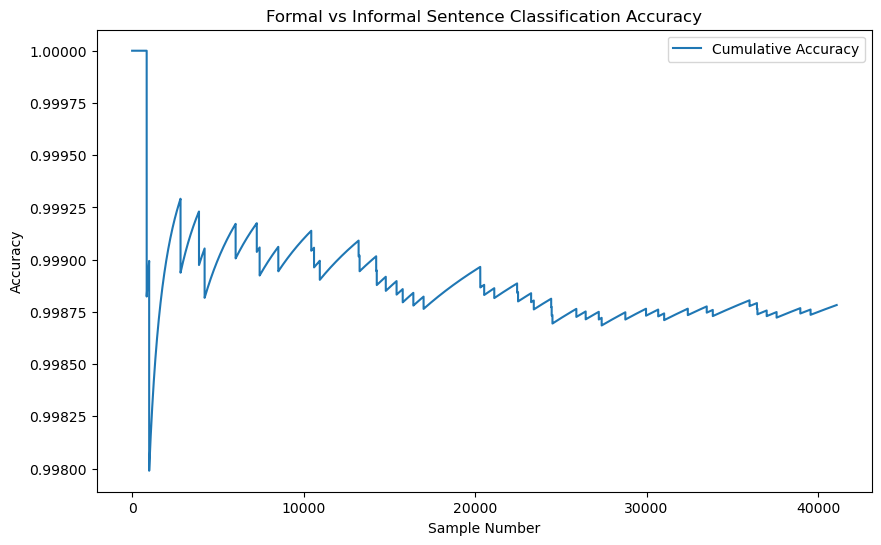

In [8]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from utils import clean
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained('./saved_model').to(device)
tokenizer = AutoTokenizer.from_pretrained('./saved_model')

class FormalClassifier(object):
    def predict(self, text: str):
        text = clean(text)
        inputs = tokenizer(
            text, return_tensors="pt", max_length=64, truncation=True, padding="max_length")
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        model_inputs = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
        }
        return torch.softmax(model(**model_inputs).logits, dim=-1)

    def is_formal(self, text):
        result = self.predict(text)
        return 1 if result[0][1] > 0.5 else 0

if __name__ == "__main__":
    # CSV 파일에서 데이터를 로드
    df = pd.read_csv('./data/test.tsv', sep='\t')
    # df에서 랜덤으로 1000개 선택
    #df = df.sample(n=1000, random_state=42)
    sentences = df['sentence']
    labels = df['label']

    classifier = FormalClassifier()
    predictions = []

    # 프로그레스바 추가
    for sentence in tqdm(sentences, desc="Classifying"):
        prediction = classifier.is_formal(sentence)
        predictions.append(prediction)

    # 정확도 계산
    cumulative_accuracy = []
    correct_predictions = 0

    for i, (label, prediction) in enumerate(zip(labels, predictions)):
        if label == prediction:
            correct_predictions += 1
        cumulative_accuracy.append(correct_predictions / (i + 1))

    print(f"Final Accuracy: {cumulative_accuracy[-1]*100:.2f}%")

    # 정확도 그래프 저장
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_accuracy) + 1), cumulative_accuracy, label='Cumulative Accuracy')
    plt.xlabel('Sample Number')
    plt.ylabel('Accuracy')
    plt.title('Formal vs Informal Sentence Classification Accuracy')
    plt.legend()
    plt.savefig('./accuracy_results.png')
    plt.show()
